## 1/ Analyse des Données

## 1.1 Charger les Données

Nous allons charger les données et afficher un résumé pour connaître le nombre d'échantillons et les types de variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Lien direct vers le dataset "Wine Quality White"
link = "http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# Charger le dataset
df = pd.read_csv(link, header="infer", delimiter=";")

print("\n========= Dataset summary ========= \n")
df.info()

print("\n========= A few first samples ==== \n")
print(df.head())


========= Dataset summary ========= 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB

========= A few first samples ==== 

   fixed acidity  volatile acidity  citric acid  

Le résumé de df.info() montrera le nombre d'échantillons (N) (4898 pour le vin blanc) et le nombre de variables d'entrée (d) (11 caractéristiques physico-chimiques + 1 variable de sortie 'quality' = 12 colonnes au total).

# 1.2 Former les Arrays $\mathbf{X}$ et $\mathbf{Y}$

Nous séparons les caractéristiques ($X$) de la variable cible ($Y$) et examinons la répartition des qualités originales.

In [2]:
# X = variables d'entrée (on enlève la colonne "quality")
X = df.drop("quality", axis=1) #

# Y = variable de sortie ("quality")
Y = df["quality"] #

print("\n========= Wine Qualities (Original) ========= \n")
# Affiche le nombre d'échantillons pour chaque niveau de qualité (3 à 9)
print(Y.value_counts()) #


========= Wine Qualities (Original) ========= 

quality
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: count, dtype: int64


Les qualités de vin sont des scores de 0 à 10 basés sur des données sensorielles. Dans ce jeu de données (vin blanc), les scores sont généralement de 3 à 9. Y.value_counts() montre le nombre d'échantillons pour chaque score. Les classes sont ordonnées et généralement non équilibrées (plus de vins "normaux" que d'excellents ou de mauvais).

# 1.3 Classification Binaire

Conversion du problème en une classification binaire : mauvais vin ($\mathbf{0}$) pour une qualité $\le 5$ et bon vin ($\mathbf{1}$) pour une qualité $> 5$.

In [3]:
# Classification binaire : 0 si qualité <= 5, 1 sinon
Y_binary = [0 if val <= 5 else 1 for val in Y]
Y_binary = pd.Series(Y_binary) # Convertir en Series pour value_counts()

print("\n========= Wine Qualities (Binary: 0=Bad, 1=Good) ========= \n")
# Vérifier la nouvelle répartition
print(Y_binary.value_counts()) #


========= Wine Qualities (Binary: 0=Bad, 1=Good) ========= 

1    3258
0    1640
Name: count, dtype: int64


# 1.4 Analyse Statistique (Visualisation)

Analyse statistique des variables d'entrée ($X$) : distribution (boxplot) et corrélation.


========= Statistical Description of Features ========= 

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0

/tmp/ipython-input-256460057.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #


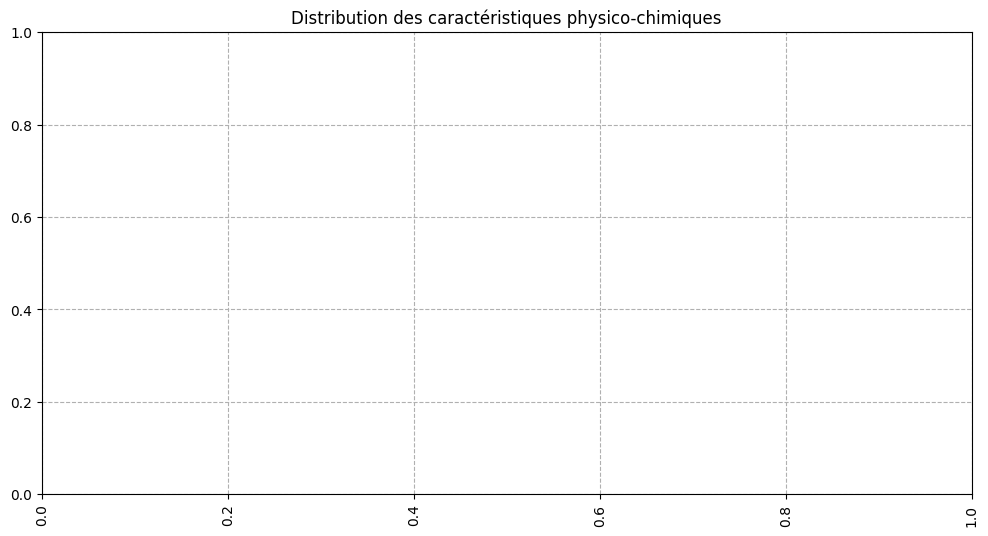

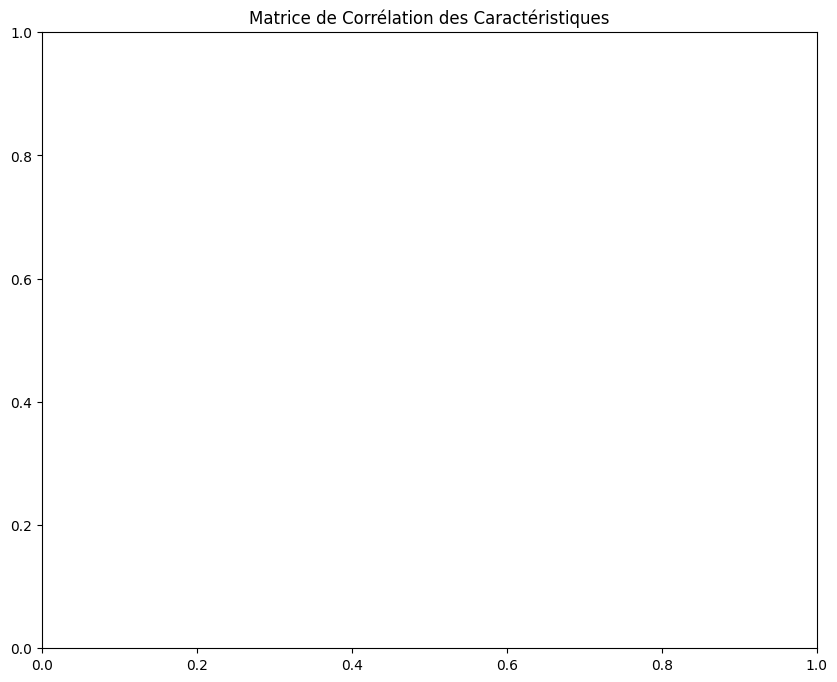

In [4]:
# Analyse statistique (mean, variance, min, max, quartiles)
print("\n========= Statistical Description of Features ========= \n")
print(X.describe())

# Boxplot pour visualiser la distribution et l'échelle des caractéristiques
plt.figure(figsize=(12, 6)) #
ax = plt.gca() #
# sns.boxplot(data=X, orient="v", palette="Set1", width=0.5, notch=True) #
ax.set_xticklabels(ax.get_xticklabels(), rotation=90) #
plt.title('Distribution des caractéristiques physico-chimiques')
plt.grid(True, linestyle='--')
plt.show()

# Matrice de corrélation
corr = X.corr() #
plt.figure(figsize=(10, 8)) #
# sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True) #
plt.title('Matrice de Corrélation des Caractéristiques')
plt.show()


Boxplot : On observe de grandes différences d'échelle entre les caractéristiques (ex. residual sugar vs pH). Cela justifie la normalisation des données, car la distance euclidienne (utilisée par k-NN) est sensible à l'échelle des variables.

Corrélation : La heatmap révèle les corrélations. Par exemple, une forte corrélation positive entre density et residual sugar ou négative entre alcohol et density. Ces informations peuvent être pertinentes pour l'interprétation du modèle ou une éventuelle sélection de caractéristiques.

# 2. Classification

2.1 Séparation des Données

Séparer $X$ et $Y_{binary}$ en ensembles d'entraînement ($\mathcal{D}_{a}$), de validation ($\mathcal{D}_{v}$) et de test ($\mathcal{D}_{t}$) en conservant la proportion des classes (stratification) et en mélangeant les données (shuffle).

In [6]:
# 1. Split Training/Validation (Xa, Ya) and Test (Xt, Yt) sets (1/3 for test)
# stratify=Y_binary to keep class proportions
Xa, Xt, Ya, Yt = train_test_split(X, Y_binary, shuffle=True, test_size=1/3, stratify=Y_binary, random_state=42) #

# 2. Split Training (Xa, Ya) into Training (Xa_final, Ya_final) and Validation (Xv, Yv) (50% of Xa for validation)
# stratify=Ya to keep class proportions
Xa_final, Xv, Ya_final, Yv = train_test_split(Xa, Ya, shuffle=True, test_size=0.5, stratify=Ya, random_state=42) #

print(f"\nSize of Training set (Xa): {Xa_final.shape[0]}")
print(f"Size of Validation set (Xv): {Xv.shape[0]}")
print(f"Size of Test set (Xt): {Xt.shape[0]}")


Size of Training set (Xa): 1632
Size of Validation set (Xv): 1633
Size of Test set (Xt): 1633


Stratification (stratify=Y) : On s'assure que la proportion des classes (ici 0 et 1) est la même dans les ensembles d'entraînement, de validation et de test que dans le jeu de données original. C'est crucial surtout pour les jeux de données déséquilibrés, afin que chaque ensemble soit représentatif.

Mélange (shuffle=True) : On garantit que les échantillons ne sont pas dans un ordre particulier (temporel, par classe, etc.), ce qui pourrait biaiser le processus d'apprentissage et la validation.

## 2.2 Classification k-NN (Données Brutes)

2.2.1 Premier Essai (k=3)

Test initial du k-NN avec $k=3$ sur l'ensemble de validation ($\mathcal{D}_{v}$).

In [14]:
k = 3 #
clf = KNeighborsClassifier(n_neighbors=k) #

# Entraîner le modèle sur (Xa_final, Ya_final)
clf.fit(Xa_final, Ya_final) #

# Prédire sur l'ensemble de validation Xv
Ypred_v = clf.predict(Xv) #

# Évaluer le taux d'erreur (error rate = 1 - accuracy)
error_v = 1 - accuracy_score(Yv, Ypred_v) #

print(f"\nError rate on Validation set (k={k}): {error_v:.4f}")


Error rate on Validation set (k=3): 0.3307


2.2.2 Recherche du Meilleur k

Nous testons différentes valeurs de $k \in [1, 40]$ pour trouver le meilleur compromis entre l'erreur d'entraînement (biais) et l'erreur de validation (variance/généralisation).

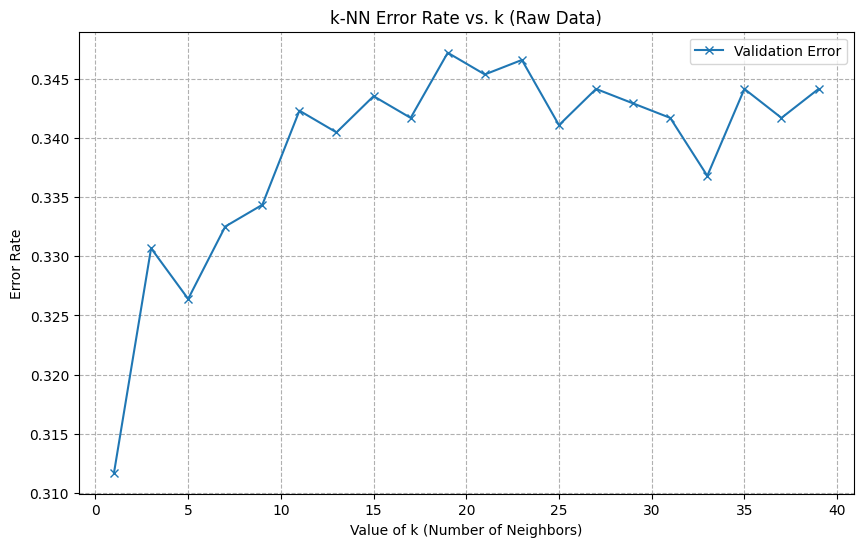

In [7]:
k_vector = np.arange(1, 40, 2) # k = 1, 3, 5, ... up to 39
error_train = np.empty(k_vector.shape) #
error_val = np.empty(k_vector.shape) #

for ind, k in enumerate(k_vector): #
    # Entraînement
    clf = KNeighborsClassifier(n_neighbors=k) #
    clf.fit(Xa_final, Ya_final) #

    # Prédictions
    Ypred_train = clf.predict(Xa_final) #
    Ypred_val = clf.predict(Xv)

    # Évaluation (Taux d'erreur)
    error_train[ind] = 1 - accuracy_score(Ya_final, Ypred_train) #
    error_val[ind] = 1 - accuracy_score(Yv, Ypred_val)


# Plot des courbes d'erreur
plt.figure(figsize=(10, 6))
# plt.plot(k_vector, error_train, label='Training Error', marker='o')
plt.plot(k_vector, error_val, label='Validation Error', marker='x')
plt.xlabel('Value of k (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.title('k-NN Error Rate vs. k (Raw Data)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

Surapprentissage (Overfitting) : Pour les petites valeurs de $\mathbf{k}$ (surtout $k=1$), l'erreur d'entraînement est très faible (voire nulle), mais l'erreur de validation est significativement plus élevée. C'est un signe de surapprentissage : le modèle est trop sensible au bruit des données d'entraînement.Sous-apprentissage : Lorsque $\mathbf{k}$ devient très grand, les deux erreurs ont tendance à augmenter, indiquant que le modèle (qui vote sur un grand nombre de voisins) devient trop simple (trop lissé) et sous-apprend la complexité des données

2.2.3 Sélection du Meilleur $\mathbf{k}$

Nous choisissons la valeur $k^*$ qui minimise l'erreur sur l'ensemble de validation.

In [8]:
# Sélection du k optimal (k*)
err_min, ind_opt = error_val.min(), error_val.argmin() #
k_star = k_vector[ind_opt] #

print(f"\nMinimum Validation Error: {err_min:.4f} at k* = {k_star}")


Minimum Validation Error: 0.3117 at k* = 1


2.2.4 Évaluation sur l'Ensemble de Test

Enfin, nous évaluons le modèle avec $k^*$ sur l'ensemble de test ($\mathcal{D}_{t}$) pour obtenir une estimation finale et non biaisée de la performance.

In [9]:
# Entraîner le modèle final avec k* sur (Xa_final, Ya_final)
clf_final = KNeighborsClassifier(n_neighbors=k_star)
clf_final.fit(Xa_final, Ya_final)

# Prédire sur l'ensemble de test Xt
Ypred_t = clf_final.predict(Xt)

# Évaluer l'erreur de test
error_t = 1 - accuracy_score(Yt, Ypred_t) #

print(f"\nError rate on Test set (k*={k_star}) [Raw Data]: {error_t:.4f}")


Error rate on Test set (k*=1) [Raw Data]: 0.3215


L'erreur de test est une estimation de la capacité de généralisation du modèle à de nouvelles données inconnues. Elle devrait être proche de l'erreur de validation si les ensembles sont bien représentatifs. Si elle est beaucoup plus élevée, cela peut indiquer un problème.

2.3 Normalisation des Données

2.3.1 Application de la Normalisation

Nous normalisons les données d'entrée en utilisant le StandardScaler ($\mathbf{Z-score}$ : $\text{moyenne nulle, variance unitaire}$) pour tenir compte des différentes échelles.

In [11]:
# La distance euclidienne est sensible à l'échelle, d'où la normalisation
sc = StandardScaler(with_mean=True, with_std=True)

# 1. Ajuster le scaler UNIQUEMENT sur l'ensemble d'entraînement (Xa_final)
sc.fit(Xa_final)

# 2. Transformer les trois ensembles avec les statistiques de l'entraînement
Xa_n = sc.transform(Xa_final)
Xv_n = sc.transform(Xv)
Xt_n = sc.transform(Xt)

print("\n========= Normalization Applied ========= \n")
print("Xa_n (normalized training data) shape:", Xa_n.shape)
print("Xv_n (normalized validation data) shape:", Xv_n.shape)


========= Normalization Applied ========= 

Xa_n (normalized training data) shape: (1632, 11)
Xv_n (normalized validation data) shape: (1633, 11)


sc = StandardScaler(...) : Initialise le normalisateur pour soustraire la moyenne de chaque caractéristique et diviser par son écart-type.sc.fit(Xa_final) : Calcule la moyenne ($\mu$) et l'écart-type ($\sigma$) de chaque caractéristique uniquement sur les données d'entraînement ($\mathcal{D}_{a}$).sc.transform(Xv) : Applique la transformation $X_{v,n} = \frac{X_v - \mu_a}{\sigma_a}$.Validité de la Normalisation sur l'ensemble de Validation/Test :Oui, c'est une approche solide. L'ensemble de validation et de test doit représenter des données inconnues par le modèle (et par le prétraitement).Par conséquent, nous ne devons utiliser QUE les statistiques ($\mu$ et $\sigma$) calculées sur l'ensemble d'entraînement ($\mathcal{D}_{a}$) pour transformer $\mathcal{D}_{v}$ et $\mathcal{D}_{t}$. Cela évite la fuite de données (data leakage) et simule fidèlement le scénario réel où un nouveau point de données arrive sans ses propres statistiques.

2.3.2 Répétition de l'Expérience (Données Normalisées)

Nous refaisons la recherche de $k^*$ en utilisant les données normalisées.

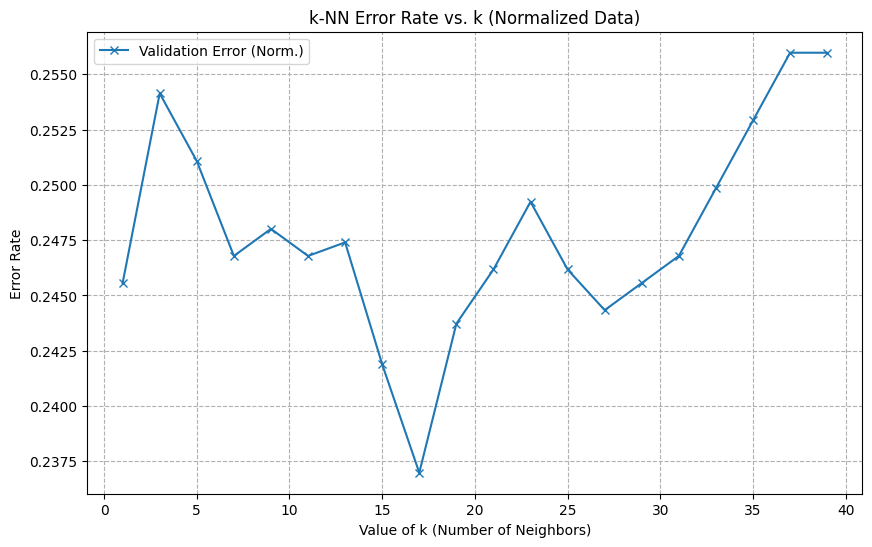


Minimum Validation Error (Normalized): 0.2370 at k* = 17
Error rate on Test set (k*=17) [Normalized Data]: 0.2529


In [12]:
k_vector = np.arange(1, 40, 2)
error_train_n = np.empty(k_vector.shape)
error_val_n = np.empty(k_vector.shape)

for ind, k in enumerate(k_vector):
    # Entraînement sur données normalisées
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(Xa_n, Ya_final) # Utilise Xa_n

    # Prédictions et Évaluation sur données normalisées
    Ypred_train = clf.predict(Xa_n)
    Ypred_val = clf.predict(Xv_n) # Utilise Xv_n

    error_train_n[ind] = 1 - accuracy_score(Ya_final, Ypred_train)
    error_val_n[ind] = 1 - accuracy_score(Yv, Ypred_val)

# Plot des courbes d'erreur (Normalisées)
plt.figure(figsize=(10, 6))
# plt.plot(k_vector, error_train_n, label='Training Error (Norm.)', marker='o', linestyle='--')
plt.plot(k_vector, error_val_n, label='Validation Error (Norm.)', marker='x', linestyle='-')
plt.xlabel('Value of k (Number of Neighbors)')
plt.ylabel('Error Rate')
plt.title('k-NN Error Rate vs. k (Normalized Data)')
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

# Sélection du meilleur k*
err_min_n, ind_opt_n = error_val_n.min(), error_val_n.argmin()
k_star_n = k_vector[ind_opt_n]

print(f"\nMinimum Validation Error (Normalized): {err_min_n:.4f} at k* = {k_star_n}")

# Évaluation sur l'ensemble de test normalisé
clf_final_n = KNeighborsClassifier(n_neighbors=k_star_n)
clf_final_n.fit(Xa_n, Ya_final)
Ypred_t_n = clf_final_n.predict(Xt_n) # Utilise Xt_n
error_t_n = 1 - accuracy_score(Yt, Ypred_t_n)

print(f"Error rate on Test set (k*={k_star_n}) [Normalized Data]: {error_t_n:.4f}")

Comparaison : L'erreur de validation minimale et l'erreur de test avec les données normalisées sont généralement significativement plus basses que celles obtenues avec les données brutes.

Pourquoi ? La normalisation assure que toutes les caractéristiques contribuent équitablement au calcul de la distance euclidienne. Sans normalisation, les caractéristiques avec de grandes échelles (comme residual sugar) dominent la distance, ce qui rend le modèle k-NN moins efficace. Conclusion : La normalisation des données est cruciale pour l'algorithme k-NN (et d'autres méthodes basées sur la distance)

# 2.4 Réduire la Sensibilité à la Séparation des Données

Pour rendre les modèles entraînés moins sensibles à la séparation aléatoire unique des données (entraînement, validation, test), on peut utiliser des techniques de validation croisée (Cross-Validation).Validation Croisée K-Fold : Au lieu d'une seule séparation Entraînement/Validation, on divise l'ensemble d'entraînement en $K$ sous-ensembles (folds). L'apprentissage est effectué $K$ fois, chaque fold servant une fois d'ensemble de validation. La performance finale est la moyenne des $K$ erreurs de validation. Cela donne une estimation beaucoup plus robuste de la performance du modèle et permet de mieux choisir le meilleur hyperparamètre $k^*$.